<a href="https://colab.research.google.com/github/ayachiii/Flow_study/blob/main/integrated_flow_rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 本文考察4.4を書くときに参考したコードである。(実際に使用したのはfocus_on_single...)

#パターンA (心拍) の上位者:スポーツのように「興奮して楽しんでいる」系のフロー

ゲームそのもののスリルを感じている人。
Zスコアによる統合
Objective Flow Score=Z(BPM)−Z(O1)

Sub Flow Score=
{fulfillment (充実感)+absorb (没入感)}/2
​


心拍数 (BPM) ➡ 「高い」ほど良い

理由: fulfillment と正の相関。

意味: 適度な覚醒・興奮状態（Arousal）にあること。

視覚野の結合 (O1 PLI) ➡ 「低い」ほど良い

理由: fast, absorb と負の相関。

意味: 視覚情報処理が効率化され、余計なノイズ活動が抑制されている（Efficiency）こと。

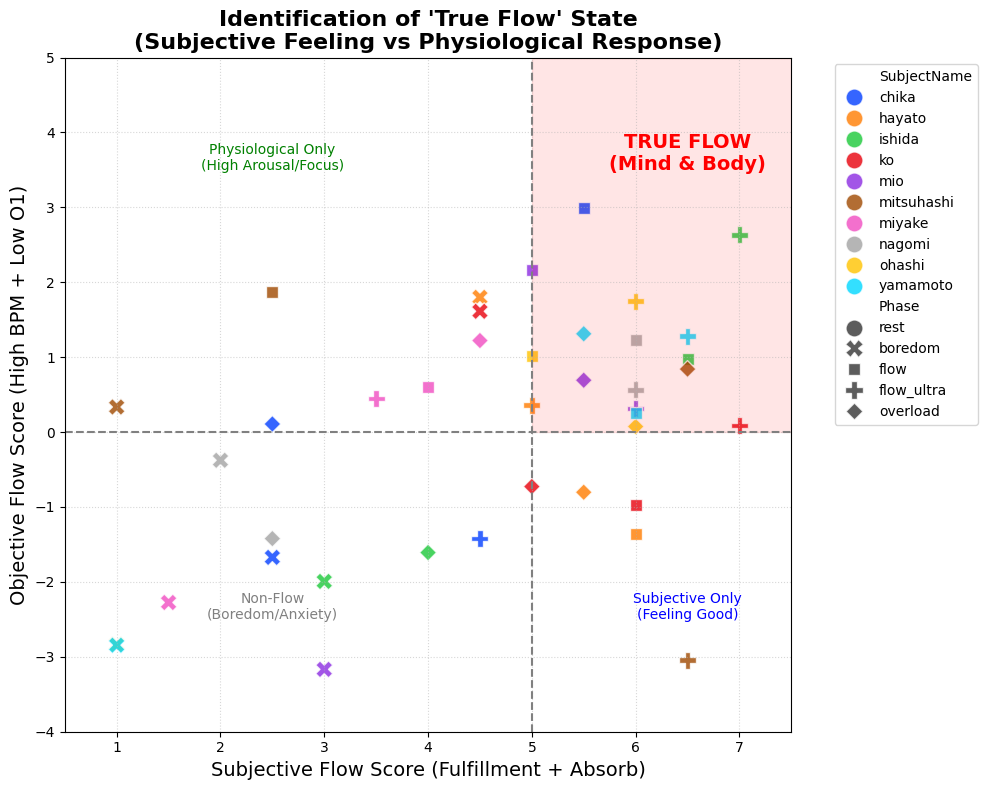


🏆 認定：心身ともにフローに入った瞬間 (True Flow List)
   基準: 主観スコア≧5 かつ 生理スコア>0
SubjectName      Phase  sub_flow_score  obj_flow_score
      chika       flow             5.5        2.985964
     ishida flow_ultra             7.0        2.632179
        mio       flow             5.0        2.158923
     ohashi flow_ultra             6.0        1.748360
   yamamoto   overload             5.5        1.311933
   yamamoto flow_ultra             6.5        1.279729
     nagomi       flow             6.0        1.234641
     ohashi       flow             5.0        1.013010
     ishida       flow             6.5        0.969822
 mitsuhashi   overload             6.5        0.840974
        mio   overload             5.5        0.692199
     nagomi flow_ultra             6.0        0.563937
     hayato flow_ultra             5.0        0.358644
        mio flow_ultra             6.0        0.316453
   yamamoto       flow             6.0        0.253471
         ko flow_ultra             7.0        0.089416
 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore


df_survey = pd.read_csv('all_survey.csv')
df_hrv    = pd.read_csv('all_hrv_data_2.csv')
df_brain  = pd.read_csv('all_brain_data.csv')

# カラム名・データクレンジング
for df in [df_survey, df_hrv, df_brain]:
    df.columns = [c.strip() for c in df.columns]
    if 'SubjectName' in df.columns:
        df['SubjectName'] = df['SubjectName'].astype(str).str.strip()
    if 'Phase' in df.columns:
        df['Phase'] = df['Phase'].astype(str).str.strip()

# 全結合
df_merged = pd.merge(df_survey, df_hrv, on=['SubjectName', 'Phase'])
df_merged = pd.merge(df_merged, df_brain, on=['SubjectName', 'Phase'])

# フェーズの順序指定
phase_order = ['rest', 'boredom', 'flow', 'flow_ultra', 'overload']
df_merged['Phase'] = pd.Categorical(df_merged['Phase'], categories=phase_order, ordered=True)
df_merged = df_merged.sort_values(['SubjectName', 'Phase'])



# 心拍 (BPM) のZスコア: 高いほど良い
df_merged['z_bpm'] = df_merged.groupby('SubjectName')['bpm'].transform(lambda x: zscore(x, nan_policy='omit'))

# 脳波 (O1) のZスコア: 低いほど良い
df_merged['z_O1'] = df_merged.groupby('SubjectName')['O1'].transform(lambda x: zscore(x, nan_policy='omit'))

# ★ 生理的フロースコア (Objective Flow Score)
# BPMが高く、O1が低いほど高得点になるように計算
df_merged['obj_flow_score'] = df_merged['z_bpm'] - df_merged['z_O1']


# 充実感と没入感の平均を「主観的フロースコア」とする
df_merged['sub_flow_score'] = (df_merged['fulfillment'] + df_merged['absorb']) / 2


plt.figure(figsize=(10, 8))


sub_thresh = 5.0
obj_thresh = 0.0

# 散布図描画
sns.scatterplot(data=df_merged, x='sub_flow_score', y='obj_flow_score',
                hue='SubjectName', style='Phase', s=150, palette='bright', alpha=0.8)

# 閾値の線
plt.axvline(x=sub_thresh, color='gray', linestyle='--')
plt.axhline(y=obj_thresh, color='gray', linestyle='--')

plt.fill_between([sub_thresh, 8], obj_thresh, 5, color='red', alpha=0.1)
plt.text(6.5, 3.5, "TRUE FLOW\n(Mind & Body)", fontsize=14, color='red', ha='center', fontweight='bold')


plt.text(6.5, -2.5, "Subjective Only\n(Feeling Good)", fontsize=10, color='blue', ha='center')


plt.text(2.5, 3.5, "Physiological Only\n(High Arousal/Focus)", fontsize=10, color='green', ha='center')


plt.text(2.5, -2.5, "Non-Flow\n(Boredom/Anxiety)", fontsize=10, color='gray', ha='center')


plt.title("Identification of 'True Flow' State\n(Subjective Feeling vs Physiological Response)", fontsize=16, fontweight='bold')
plt.xlabel("Subjective Flow Score (Fulfillment + Absorb)", fontsize=14)
plt.ylabel("Objective Flow Score (High BPM + Low O1)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0.5, 7.5)
plt.ylim(-4, 5) # スコアの範囲に合わせて調整
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()


true_flow = df_merged[
    (df_merged['sub_flow_score'] >= sub_thresh) &
    (df_merged['obj_flow_score'] > obj_thresh)
].sort_values('obj_flow_score', ascending=False)

print(f"\n{'='*60}")
print(f" 認定：心身ともにフローに入った瞬間 (True Flow List)")
print(f"   基準: 主観スコア≧5 かつ 生理スコア>0")
print(f"{'='*60}")
print(true_flow[['SubjectName', 'Phase', 'sub_flow_score', 'obj_flow_score']].to_string(index=False))

# パターンB (FCz & LF) の上位者:「ゾーン」に近い、静かで研ぎ澄まされる系のフロー心拍のムラ（LF）が消え、脳の前頭部（FCz）だけが強く働いている、プロゲーマーのような状態

Score=Z(FCz)−Z(LF)

Sub Flow Score= {fulfillment (充実感)+absorb (没入感)}/2 ​

FCz (Frontal-Central): 「認知的な集中・注意制御」を反映します（高いほうが集中）。

LF (Low Frequency): 先ほどの相関分析で、スピードが速いとき（Flow時）に「下がる傾向（負の相関）」がありました。つまり、「LFが低い＝フロー状態」と仮定できます。


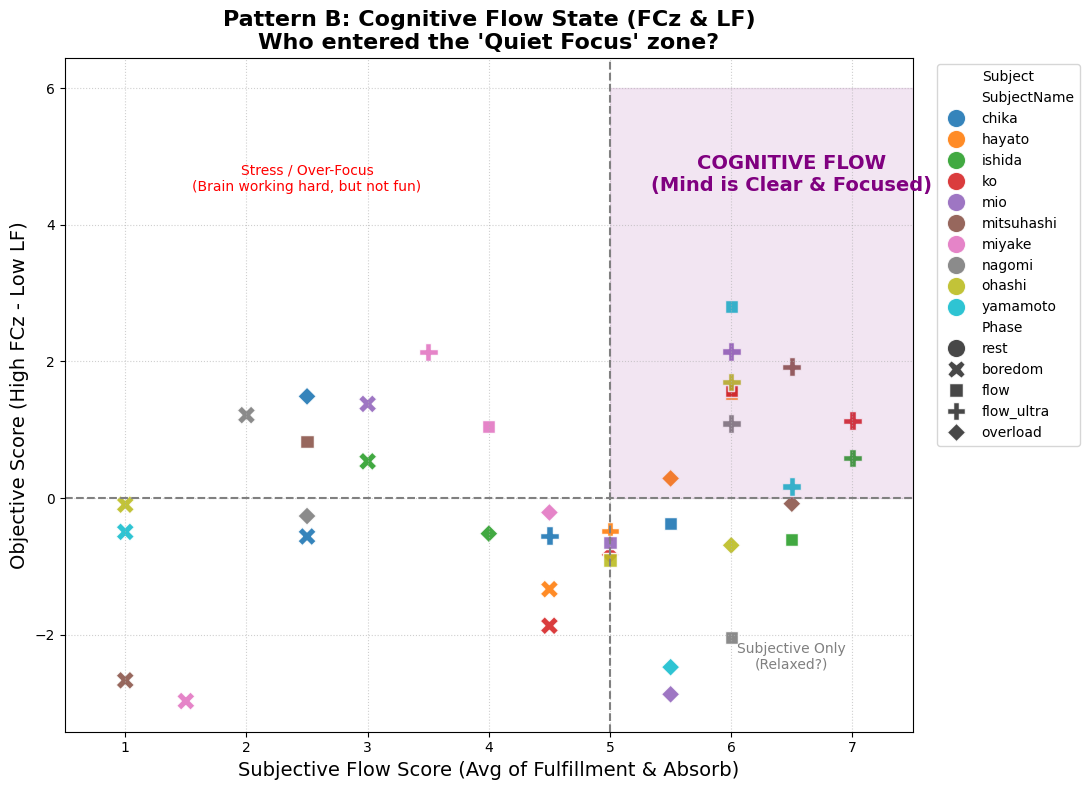


🧠 認定：『静かなる集中 (Cognitive Flow)』に入ったリスト
   (条件: 主観スコア≧5.0  かつ  客観スコア(FCz-LF) > 0)
SubjectName      Phase  sub_flow_score  obj_flow_score_cognitive
   yamamoto       flow             6.0                      2.80
        mio flow_ultra             6.0                      2.14
 mitsuhashi flow_ultra             6.5                      1.92
     ohashi flow_ultra             6.0                      1.70
         ko       flow             6.0                      1.57
     hayato       flow             6.0                      1.54
         ko flow_ultra             7.0                      1.13
     nagomi flow_ultra             6.0                      1.09
     ishida flow_ultra             7.0                      0.59
     hayato   overload             5.5                      0.29
   yamamoto flow_ultra             6.5                      0.17


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore


df_survey = pd.read_csv('all_survey.csv')
df_hrv    = pd.read_csv('all_hrv_data_2.csv')
df_brain  = pd.read_csv('all_brain_data.csv')

for df in [df_survey, df_hrv, df_brain]:
    df.columns = [c.strip() for c in df.columns]
    if 'SubjectName' in df.columns:
        df['SubjectName'] = df['SubjectName'].astype(str).str.strip()
    if 'Phase' in df.columns:
        df['Phase'] = df['Phase'].astype(str).str.strip()

df_merged = pd.merge(df_survey, df_hrv, on=['SubjectName', 'Phase'])
df_merged = pd.merge(df_merged, df_brain, on=['SubjectName', 'Phase'])

# フェーズ順序
phase_order = ['rest', 'boredom', 'flow', 'flow_ultra', 'overload']
df_merged['Phase'] = pd.Categorical(df_merged['Phase'], categories=phase_order, ordered=True)
df_merged = df_merged.sort_values(['SubjectName', 'Phase'])


df_merged['sub_flow_score'] = (df_merged['fulfillment'] + df_merged['absorb']) / 2

df_merged['z_FCz'] = df_merged.groupby('SubjectName')['FCz'].transform(lambda x: zscore(x, nan_policy='omit'))
df_merged['z_lf']  = df_merged.groupby('SubjectName')['lf'].transform(lambda x: zscore(x, nan_policy='omit'))

df_merged['obj_flow_score_cognitive'] = df_merged['z_FCz'] - df_merged['z_lf']


plt.figure(figsize=(11, 8))

# 閾値設定
sub_thresh = 5.0  # 主観のボーダーライン
obj_thresh = 0.0  # 客観のボーダーライン (平均以上)

# 散布図
# palette='tab10' を使うことで、10人までくっきり違う色になります
sns.scatterplot(data=df_merged, x='sub_flow_score', y='obj_flow_score_cognitive',
                hue='SubjectName', style='Phase', s=180, palette='tab10', alpha=0.9)

# 閾値の線
plt.axvline(x=sub_thresh, color='gray', linestyle='--')
plt.axhline(y=obj_thresh, color='gray', linestyle='--')

# ゾーンの色付け (右上の「Cool Flow」エリア)
plt.fill_between([sub_thresh, 8], obj_thresh, 6, color='purple', alpha=0.1)

# ラベル配置
plt.text(6.5, 4.5, "COGNITIVE FLOW\n(Mind is Clear & Focused)", fontsize=14, color='purple', ha='center', fontweight='bold')
plt.text(6.5, -2.5, "Subjective Only\n(Relaxed?)", fontsize=10, color='gray', ha='center')
plt.text(2.5, 4.5, "Stress / Over-Focus\n(Brain working hard, but not fun)", fontsize=10, color='red', ha='center')

plt.title("Pattern B: Cognitive Flow State (FCz & LF)\nWho entered the 'Quiet Focus' zone?", fontsize=16, fontweight='bold')
plt.xlabel("Subjective Flow Score (Avg of Fulfillment & Absorb)", fontsize=14)
plt.ylabel("Objective Score (High FCz - Low LF)", fontsize=14)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Subject')
plt.xlim(0.5, 7.5)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()


cog_flow_list = df_merged[
    (df_merged['sub_flow_score'] >= sub_thresh) &
    (df_merged['obj_flow_score_cognitive'] > obj_thresh)
].sort_values('obj_flow_score_cognitive', ascending=False)

print(f"\n{'='*70}")
print(f" 認定：『静かなる集中 (Cognitive Flow)』に入ったリスト")
print(f"   (条件: 主観スコア≧5.0  かつ  客観スコア(FCz-LF) > 0)")
print(f"{'='*70}")
print(cog_flow_list[['SubjectName', 'Phase', 'sub_flow_score', 'obj_flow_score_cognitive']].round(2).to_string(index=False))

focus_on_single_subjectへ